In [8]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '2'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend
from tensorflow.keras import layers
import numpy as np 
from matplotlib import pyplot as plt
import cv2

In [13]:
img_size = (112, 112)   # 图片尺寸
input_shape = (112, 112, 3)  # 模型输入尺寸
epochs = 100    # 训练迭代次数
batch_size = 128   # 批处理
initial_lr = 0.01  # 初始学习率
train_dir = r'./cld_train_data/train'
test_dir = r'./cld_train_data/test'

In [3]:
# prepocess input
def preprocess_input(inputs, std=255., mean=0):
    inputs = tf.cast(inputs, tf.float32)
    inputs = (inputs - mean) / std  # 归一化
    return inputs

# load data
def load_data(data_dir, img_size):
    x = []
    y = []
    for label in os.listdir(data_dir):
        path = os.path.join(data_dir, label)
        label = np.uint8(label)
        for img_file in os.listdir(path):
            img = cv2.imread(os.path.join(path,img_file))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, img_size)
            x.append(img)
            y.append(label)
    y = np.expand_dims(y, axis=-1)
    return x, y     

In [4]:
# 生成tensorflow数据通道
x_train, y_train = load_data(train_dir, img_size)
x_test, y_test = load_data(test_dir, img_size)

x_test = preprocess_input(x_test)
x_train_ds = tf.data.Dataset.from_tensor_slices(x_train).map(preprocess_input)
y_train_ds = tf.data.Dataset.from_tensor_slices(y_train)
x_y_train_ds = tf.data.Dataset.zip((x_train_ds,y_train_ds))
x_y_train_ds = x_y_train_ds.shuffle(6500).batch(batch_size)

In [52]:
# 使用深度可分离卷积块，创建模型
def model_dep(input_shape, dropout_rate):
    input = keras.Input(shape=input_shape)
    x = layers.Conv2D(8, (3, 3), strides=1, padding='same')(input)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(16, (1, 1), strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.DepthwiseConv2D(kernel_size=(3, 3), strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(64, (3, 3), strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(64, (1, 1), strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.DepthwiseConv2D(kernel_size=(3, 3), strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(64, (1, 1), strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(32, (1, 1), strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.DepthwiseConv2D(kernel_size=(3, 3), strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(64, (1, 1), strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(32, (1, 1), strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.DepthwiseConv2D(kernel_size=(3, 3), strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(128, (1, 1), strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(4)(x)
    x = layers.Softmax()(x)
    
    return keras.Model(inputs=input, outputs=x)

In [53]:
# learning rate 随着 epoch 指数递减
lr_schedules = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_lr,
        decay_steps=10,
        staircase=True,
        decay_rate=0.5)

# 训练模型
model = model_dep(input_shape, dropout_rate=0.3)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedules)
earlystop = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10,verbose=1)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_y_train_ds, validation_data=(x_test, y_test), callbacks=[earlystop], epochs=epochs)

Epoch 1/100
45/45 [==============================] - 5s 85ms/step - loss: 0.3700 - accuracy: 0.8352 - val_loss: 1.5636 - val_accuracy: 0.2500
Epoch 2/100
45/45 [==============================] - 4s 75ms/step - loss: 0.2437 - accuracy: 0.8938 - val_loss: 1.9581 - val_accuracy: 0.2500
Epoch 3/100
45/45 [==============================] - 4s 76ms/step - loss: 0.2383 - accuracy: 0.8945 - val_loss: 2.3005 - val_accuracy: 0.2500
Epoch 4/100
45/45 [==============================] - 4s 76ms/step - loss: 0.2323 - accuracy: 0.9013 - val_loss: 2.5508 - val_accuracy: 0.2500
Epoch 5/100
45/45 [==============================] - 4s 74ms/step - loss: 0.2380 - accuracy: 0.8959 - val_loss: 2.7021 - val_accuracy: 0.2500
Epoch 6/100
45/45 [==============================] - 4s 75ms/step - loss: 0.2328 - accuracy: 0.8994 - val_loss: 2.7599 - val_accuracy: 0.2500
Epoch 7/100
45/45 [==============================] - 4s 75ms/step - loss: 0.2354 - accuracy: 0.8974 - val_loss: 2.7329 - val_accuracy: 0.2500
Epoch 

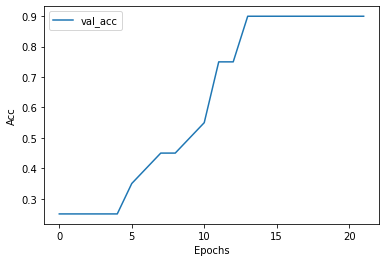

In [35]:
plt.plot(history.history['val_accuracy'],label='val_acc')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.show()

In [39]:
model.save('checkpoint/cld_float32.h5')